#Planteamiento del problema

######En este desafío, queremos explorar cómo Machine Learning puede ayudar con la identificación de serpientes, con el fin de reducir potencialmente las acciones de atención médica erróneas y retrasadas y mejorar los datos ecoepidemiológicos de mordeduras de serpientes.

###Cargamos las librerias necesarias para el procesamiento de datos

In [ ]:
import os
import sys
import cv2
from PIL import Image
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import imageio as io

In [ ]:
!pip install -q kaggle

In [ ]:
 from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"juandavidporrasgomez","key":"8dc2faf1ee5cfc4db99e372d979ad478"}'}

In [ ]:
 !mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
 !kaggle datasets download -d goelyash/165-different-snakes-species

 99% 3.18G/3.20G [01:00<00:00, 69.6MB/s]
100% 3.20G/3.20G [01:00<00:00, 57.0MB/s]


In [ ]:
!ls

165-different-snakes-species.zip  kaggle.json  sample_data


In [ ]:
 !unzip 165-different-snakes-species.zip

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: train/672/234f6efd877d4945a573d8797d19fa2c.jpg  
  inflating: train/672/2362310f6d074029968ce831f9527c13.jpg  
  inflating: train/672/239b238b09124731aa0cdff0a181834b.jpg  
  inflating: train/672/23b769e0df8a4993b849474d5712186c.jpg  
  inflating: train/672/24c185b8ee2f45e8a11730db85e9cd5e.jpg  
  inflating: train/672/26d1f908ed8c401782ab44b99d057862.jpg  
  inflating: train/672/278dd1d3b03a494eaedc40eacebe660a.jpg  
  inflating: train/672/2790963e7d434186ae863ed9ff77b112.jpg  
  inflating: train/672/299b521236784ed29862c17c3b12ef81.jpg  
  inflating: train/672/29e0a1c48cf748c9b02daa7d5c9e83e9.jpg  
  inflating: train/672/2f8d3fe40c4047d585222394f557ccea.jpg  
  inflating: train/672/3045d1ce94514b0b9ecd1511de1ac5db.jpg  
  inflating: train/672/310f3d9e4d884bae8b1205c7086b029f.jpg  
  inflating: train/672/319df8bb6cf44c99abbaa02f09ff8e26.jpg  
  inflating: train/672/3336bb85d92d4a198ec037c7d60e1b2e.jpg  
  i

In [ ]:
!ls

165-different-snakes-species.zip  Csv  kaggle.json  sample_data  test  train


In [ ]:
!pwd

/content


#Herramientas de trabajo

######Se invesigo y obtuvo un datasets con un conjunto de datos de imágenes RGB de serpientes y su correspondiente especie (clase) y ubicación geográfica (continente, país). El objetivo es crear un sistema que sea capaz de clasificar automáticamente las serpientes a nivel de especie.

In [ ]:
train = pd.read_csv('Csv/train.csv')
test = pd.read_csv('Csv/test.csv')
print(train.shape, test.shape)
train.head()

(23816, 14) (3138, 10)


,Unnamed: 0,binomial,country,continent,genus,family,UUID,class_id,snake_sub_family,poisonous,X,Y,height,width
0,0,Agkistrodon contortrix,United States of America,North America,Agkistrodon,Viperidae,20e23008100d4e249fd757c11fe059fe,18,Agkistrodon contortrix,1,0.507412,0.546939,0.916220,0.951425
1,1,Agkistrodon contortrix,United States of America,North America,Agkistrodon,Viperidae,0c6d14f33f404013ab116ab09880c523,18,Agkistrodon contortrix,1,0.503115,0.392086,0.835316,0.965363
2,2,Agkistrodon contortrix,United States of America,North America,Agkistrodon,Viperidae,3a31a32de0434653b4a82a30806f7a6d,18,Agkistrodon contortrix,1,0.353031,0.573312,0.652700,0.709286
3,3,Agkistrodon contortrix,United States of America,North America,Agkistrodon,Viperidae,1c5a3b2953c84d698fad8a40db91323e,18,Agkistrodon contortrix,1,0.436368,0.447794,0.918880,0.834457
4,4,Agkistrodon contortrix,United States of America,North America,Agkistrodon,Viperidae,e10c99a58c2546dab2c0d998de1f7c1b,18,Agkistrodon contortrix,1,0.512284,0.519067,0.923202,0.631036


Datos de Train

In [ ]:
train_DF = []
for i in range(len(train)):
  path = 'train/{}/{}.jpg'.format( train.iloc[i]['class_id'], train.iloc[i]['UUID'])
  label = train.iloc[i]['binomial']
  train_DF.append([path,label])

train_DF = pd.DataFrame(train_DF)
train_DF.columns = ['path','label']
print(train_DF.shape)
train_DF.head()

(23816, 2)


,path,label
0,train/18/20e23008100d4e249fd757c11fe059fe.jpg,Agkistrodon contortrix
1,train/18/0c6d14f33f404013ab116ab09880c523.jpg,Agkistrodon contortrix
2,train/18/3a31a32de0434653b4a82a30806f7a6d.jpg,Agkistrodon contortrix
3,train/18/1c5a3b2953c84d698fad8a40db91323e.jpg,Agkistrodon contortrix
4,train/18/e10c99a58c2546dab2c0d998de1f7c1b.jpg,Agkistrodon contortrix


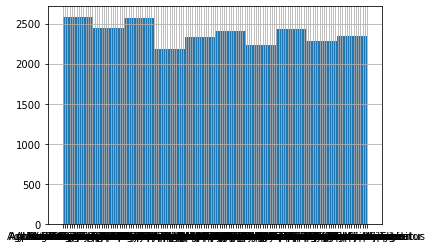

In [ ]:
train_DF['label'].hist()

Datos de Test

In [ ]:
test_DF = []
for i in range(len(test)):
  path = 'test/{}/{}.jpg'.format( test.iloc[i]['class_id'], test.iloc[i]['UUID'])
  label = test.iloc[i]['binomial']
  test_DF.append([path,label])

test_DF = pd.DataFrame(test_DF)
test_DF.columns = ['path','label']
print(test_DF.shape)
test_DF.head()

(3138, 2)


,path,label
0,test/18/ca23ee722e5e4b6ca4b130291b8428f1.jpg,Agkistrodon contortrix
1,test/18/23dfe346fcbf40e7a465b0febf3620be.jpg,Agkistrodon contortrix
2,test/18/2c96953bd06645bdbfa87b180eb72b0f.jpg,Agkistrodon contortrix
3,test/18/e2bcec60b133466380d5c253088765ae.jpg,Agkistrodon contortrix
4,test/18/fd6a488d065e47978c9996734fc1732c.jpg,Agkistrodon contortrix


Se toma N clases aleatorias del dataset original

In [ ]:
def filter(labels,data_df):
  data = pd.DataFrame()
  for i in labels:
    datalabel = data_df[ data_df['label'] == i ]
    data = pd.concat([data,datalabel])
  return data

In [ ]:
N = 10
labels = np.array(list(set(train_DF['label'])))
lbl = np.random.choice(labels, size=N, replace=False)

train_df = filter(lbl,train_DF)
test_df = filter(lbl,test_DF)

train_df.shape, test_df.shape

((1669, 2), (229, 2))

Se cargan las imagenes de test en memoria

In [ ]:
test_images = []

for i in test_df['path']:
  img = tf.keras.preprocessing.image.load_img(i, target_size=(200,200))
  ima = tf.keras.preprocessing.image.img_to_array(img);
  test_images.append(ima)
test_images = np.array(test_images).astype('int32')

In [ ]:
test_images.shape

(229, 200, 200, 3)

In [ ]:
test_images = test_images.reshape([-1,200,200,3])
test_images = test_images.astype('float32')
test_images /= 255

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
test_labels = label_encoder.fit_transform(test_df['label'].values)
test_labels =  tf.keras.utils.to_categorical(test_labels)

test_labels

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

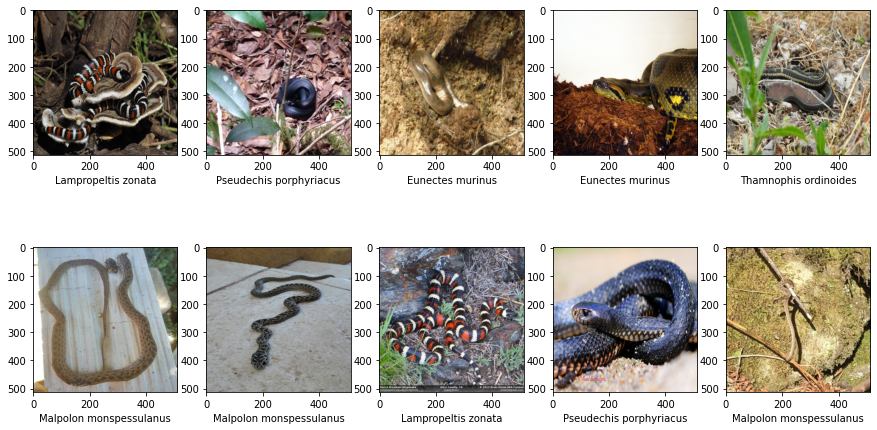

In [ ]:
fig = plt.figure(figsize=(15,8))

for i in range(10):
  index = np.random.randint(len(train_df))
  plt.subplot(2,5,i+1)
  image = io.imread(train_df.iloc[index]['path'])
  plt.imshow(image)
  plt.xlabel(train_df.iloc[index]['label'])

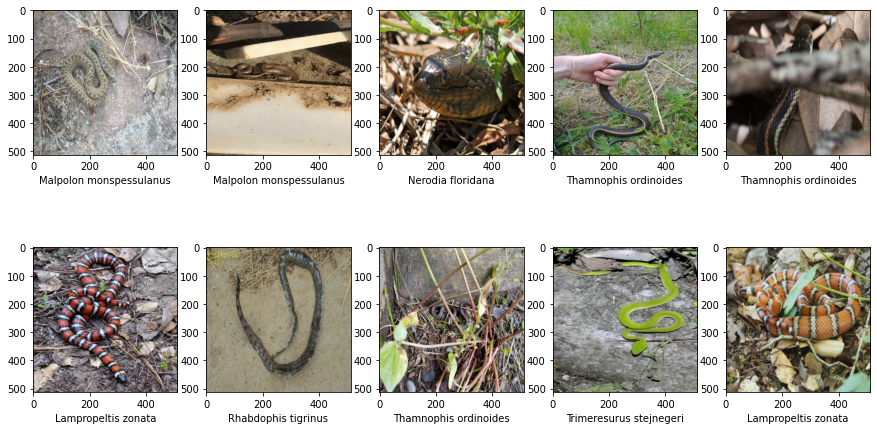

In [ ]:
fig = plt.figure(figsize=(15,8))

for i in range(10):
  index = np.random.randint(len(test_df))
  plt.subplot(2,5,i+1)
  image = io.imread(test_df.iloc[index]['path'])
  plt.imshow(image)
  plt.xlabel(test_df.iloc[index]['label'])

In [ ]:
generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255.,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    rotation_range=40,
    brightness_range=[0.4,1.5],
    validation_split=0.2
    )

In [ ]:
train_generator = generator.flow_from_dataframe(
    dataframe=train_df,
    directory=None,
    subset='training',
    x_col='path',
    y_col='label',
    shuffle=True,
    batch_size=1,
    target_size=(200,200)
)

Found 1336 validated image filenames belonging to 10 classes.


In [ ]:
train_generator.class_indices

{'Crotalus ornatus': 0,
 'Eunectes murinus': 1,
 'Lampropeltis zonata': 2,
 'Malpolon monspessulanus': 3,
 'Nerodia floridana': 4,
 'Pseudechis porphyriacus': 5,
 'Rhabdophis tigrinus': 6,
 'Thamnophis cyrtopsis': 7,
 'Thamnophis ordinoides': 8,
 'Trimeresurus stejnegeri': 9}

In [ ]:
test_generator = generator.flow_from_dataframe(
    dataframe=test_df,
    directory=None,
    subset='validation',
    x_col='path',
    y_col='label',
    shuffle=True,
    batch_size=1000,
    target_size=(200,200)
)

Found 45 validated image filenames belonging to 10 classes.


In [ ]:
speciesTrain = {}
dic = train_generator.class_indices
for i in dic:
  speciesTrain.update({dic[i]:i})
speciesTrain

{0: 'Crotalus ornatus',
 1: 'Eunectes murinus',
 2: 'Lampropeltis zonata',
 3: 'Malpolon monspessulanus',
 4: 'Nerodia floridana',
 5: 'Pseudechis porphyriacus',
 6: 'Rhabdophis tigrinus',
 7: 'Thamnophis cyrtopsis',
 8: 'Thamnophis ordinoides',
 9: 'Trimeresurus stejnegeri'}

In [ ]:
s = next(train_generator)              #Se genera una nueva imagen con su clase
print( speciesTrain[np.argmax(s[1])] ) #Se imprime la clase correspondiente 
print(s[1])                            #Se imprime la clase correspondiente en OneHotEncoding
np.argmax(s[1])                        #Indice correspondiente a la clase

Nerodia floridana
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


4

In [ ]:
next(train_generator)[0].shape

(1, 200, 200, 3)

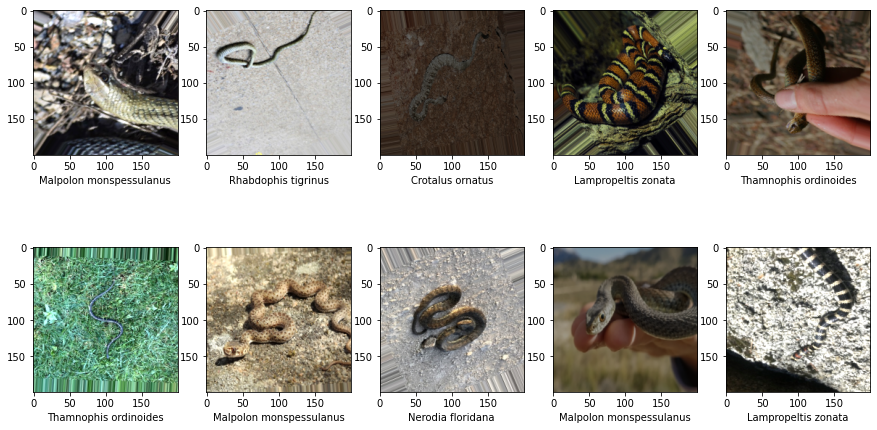

In [ ]:
fig = plt.figure(figsize=(15,8))

for i in range(10):
  plt.subplot(2,5,i+1)
  serpiente = next(train_generator)
  image = np.squeeze(serpiente[0])
  plt.imshow(image)
  plt.xlabel(speciesTrain[np.argmax(serpiente[1])])

In [ ]:
train_generator = generator.flow_from_dataframe(
    dataframe=train_df,
    directory=None,
    subset='training',
    x_col='path',
    y_col='label',
    shuffle=True,
    batch_size=N*10,
    target_size=(200,200)
)

Found 1336 validated image filenames belonging to 10 classes.


#Transfer Learning

In [ ]:
model_Imp =  tf.keras.applications.DenseNet121(input_shape=(200,200, 3), weights='imagenet', include_top=False)
model_Imp.trainable = False
model_Imp.summary()

29097984/29084464 [==============================] - 0s 0us/step
Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 206, 206, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 100, 100, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                       

In [ ]:
prediction_layer = tf.keras.layers.Dense( N , activation='softmax')
flatten_layer = tf.keras.layers.Flatten()
global_average_layer = tf.keras.layers.GlobalAveragePooling2D() 

In [ ]:
model_Imp.trainable = True
for layer in model_Imp.layers[:-5]:
  layer.trainable = False

In [ ]:
modeloAgg = tf.keras.Sequential([
  model_Imp,
  global_average_layer,
  prediction_layer
])

In [ ]:
modeloAgg.summary()
print("number of layers to train: ", len(modeloAgg.trainable_variables))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 6, 6, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 10)                10250     
                                                                 
Total params: 7,047,754
Trainable params: 49,162
Non-trainable params: 6,998,592
_________________________________________________________________
number of layers to train:  5


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience=3, restore_best_weights = True)

#learning_rate= 0.1
opt = tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9)#Adam(learning_rate=learning_rate)
modeloAgg.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])
history = modeloAgg.fit(train_generator, epochs=30, validation_data=(test_images, test_labels), callbacks=[early_stopping])

Epoch 1/30
14/14 [==============================] - 48s 2s/step - loss: 2.3096 - accuracy: 0.2133 - val_loss: 2.6978 - val_accuracy: 0.2838
Epoch 2/30
14/14 [==============================] - 24s 2s/step - loss: 1.6124 - accuracy: 0.4117 - val_loss: 2.4359 - val_accuracy: 0.3799
Epoch 3/30
14/14 [==============================] - 27s 2s/step - loss: 1.2704 - accuracy: 0.5763 - val_loss: 2.1822 - val_accuracy: 0.4410
Epoch 4/30
14/14 [==============================] - 24s 2s/step - loss: 1.1434 - accuracy: 0.5996 - val_loss: 2.0464 - val_accuracy: 0.4978
Epoch 5/30
14/14 [==============================] - 24s 2s/step - loss: 1.0738 - accuracy: 0.6377 - val_loss: 1.9656 - val_accuracy: 0.5109
Epoch 6/30
14/14 [==============================] - 24s 2s/step - loss: 1.0461 - accuracy: 0.6415 - val_loss: 1.8488 - val_accuracy: 0.5415
Epoch 7/30
14/14 [==============================] - 24s 2s/step - loss: 0.9840 - accuracy: 0.6519 - val_loss: 1.9497 - val_accuracy: 0.5153
Epoch 8/30
14/14 [==

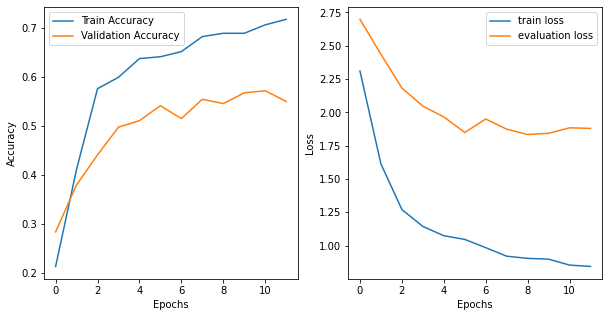

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['accuracy'], label='Train Accuracy');
ax.plot(history.history['val_accuracy'], label='Validation Accuracy');
ax.set_xlabel('Epochs');
ax.set_ylabel('Accuracy');
ax.legend();
ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['loss'], label='train loss');
ax.plot(history.history['val_loss'], label='evaluation loss');
ax.legend();
ax.set_xlabel('Epochs');
ax.set_ylabel('Loss');


Se realizan predicciones

In [ ]:
predict = modeloAgg.predict(test_images)
pred = []
for i in predict:
  pred.append(speciesTrain[np.argmax(i)])
pred

['Thamnophis ordinoides',
 'Pseudechis porphyriacus',
 'Malpolon monspessulanus',
 'Thamnophis ordinoides',
 'Rhabdophis tigrinus',
 'Malpolon monspessulanus',
 'Thamnophis ordinoides',
 'Thamnophis ordinoides',
 'Pseudechis porphyriacus',
 'Nerodia floridana',
 'Eunectes murinus',
 'Thamnophis ordinoides',
 'Crotalus ornatus',
 'Thamnophis ordinoides',
 'Thamnophis ordinoides',
 'Thamnophis ordinoides',
 'Thamnophis ordinoides',
 'Nerodia floridana',
 'Pseudechis porphyriacus',
 'Malpolon monspessulanus',
 'Trimeresurus stejnegeri',
 'Nerodia floridana',
 'Nerodia floridana',
 'Malpolon monspessulanus',
 'Malpolon monspessulanus',
 'Pseudechis porphyriacus',
 'Pseudechis porphyriacus',
 'Eunectes murinus',
 'Trimeresurus stejnegeri',
 'Malpolon monspessulanus',
 'Rhabdophis tigrinus',
 'Rhabdophis tigrinus',
 'Pseudechis porphyriacus',
 'Eunectes murinus',
 'Malpolon monspessulanus',
 'Trimeresurus stejnegeri',
 'Nerodia floridana',
 'Pseudechis porphyriacus',
 'Malpolon monspessulanu

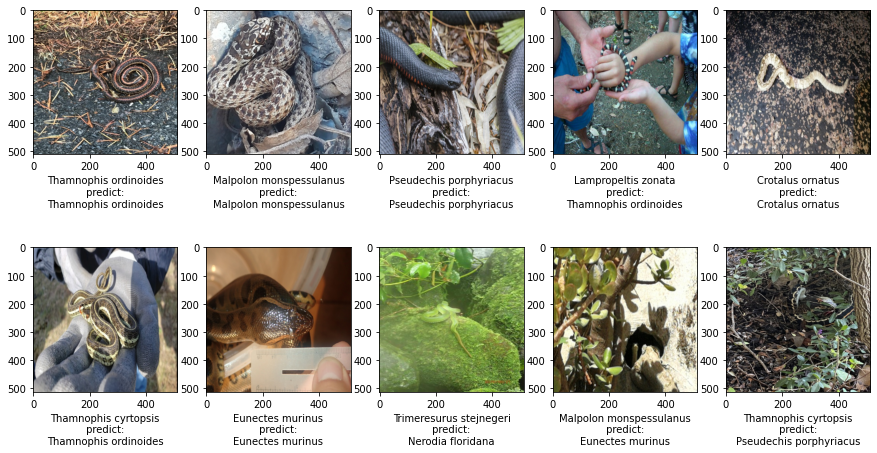

In [ ]:
fig = plt.figure(figsize=(15,8))

for i in range(10):
  index = np.random.randint(len(test_df))
  label_predict = pred[index]
  plt.subplot(2,5,i+1)
  image = io.imread(test_df.iloc[index]['path'])
  plt.imshow(image)
  plt.xlabel(test_df.iloc[index]['label'] + '\n predict: \n' + label_predict)

In [ ]:
#@title 1. MONTAR EL DRIVE  (If you are in in colab){ display-mode: "form" }
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/ProyectoIA2')
print(os.getcwd())

In [ ]:
modeloAgg.save('modeldensenet-100c.h5')